# Laboratory 1

### Configuration

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import pandas as pd


TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfaces

[Available colors](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Available points markers](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [7]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines
    
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Next')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Previous')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Add point')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Add line')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Add figure')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Solution

In [8]:
import random
import math
%matplotlib notebook

## a) 10<sup>5</sup> random points from [-1000, 1000]

<IPython.core.display.Javascript object>


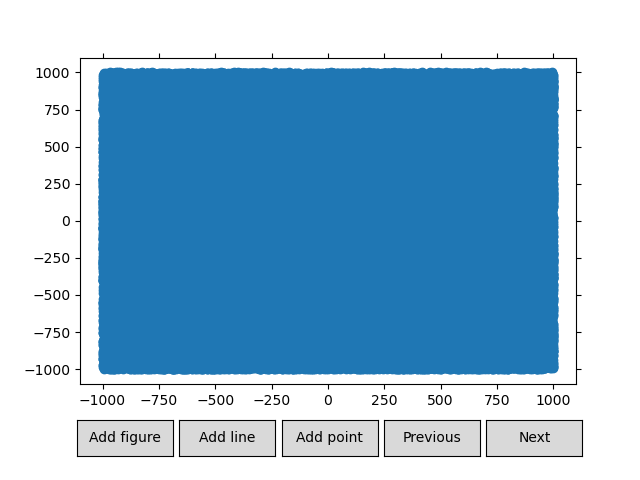

In [69]:
A = [(random.uniform(-1000, 1000), random.uniform(-1000, 1000)) for _ in range(10**5)]
A_single = [(np.single(random.uniform(-1000, 1000)), np.single(random.uniform(-1000, 1000))) for _ in range(10**5)]
plot = Plot(points = [PointsCollection(A)])
plot.draw()

## b) 10<sup>5</sup> random points from [-10<sup>14</sup>, 10<sup>14</sup>]

<IPython.core.display.Javascript object>


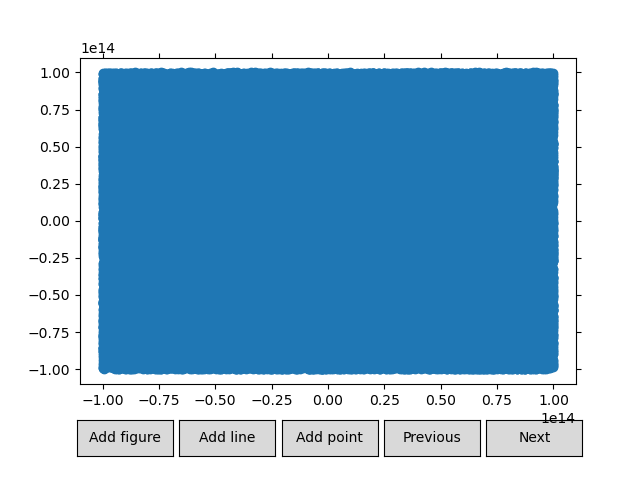

In [70]:
B = [(random.uniform(-10**14, 10**14), random.uniform(-10**14, 10**14)) for _ in range(10**5)]
B_single = [(np.single(random.uniform(-10**14, 10**14)), np.single(random.uniform(-10**14, 10**14))) for _ in range(10**5)]
plot = Plot(points = [PointsCollection(B)])
plot.draw()

## c) 1000 random points on the circle with centre at (0,0) and radius R=100

<IPython.core.display.Javascript object>


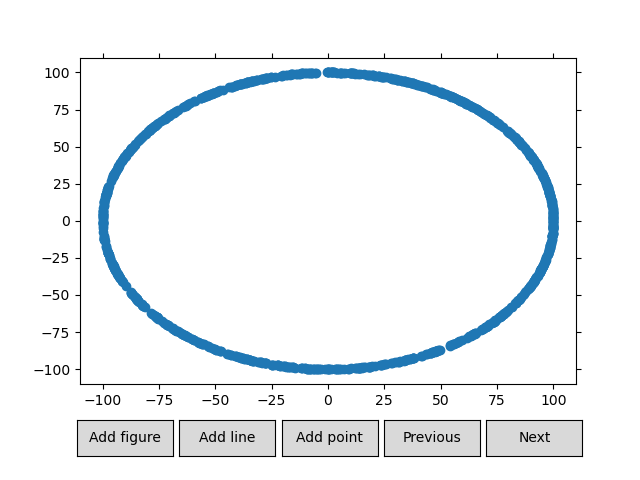

In [71]:
C = []
C_single = []
R = 100
for _ in range(1000):
    fi = random.uniform(0, 2 * math.pi)
    C.append((R * math.cos(fi), R * math.sin(fi)))
    C_single.append((np.single(R) * np.single(math.cos(np.single(fi))), np.single(R) * np.single(math.sin(np.single(fi)))))
    
plot = Plot(points = [PointsCollection(C)])
plot.draw()

## d) 1000 random points from [-1000, 1000] lying on the line defined by the vector (a, b), a = [-1.0, 0.0], b = [1.0, 0.1]

<IPython.core.display.Javascript object>


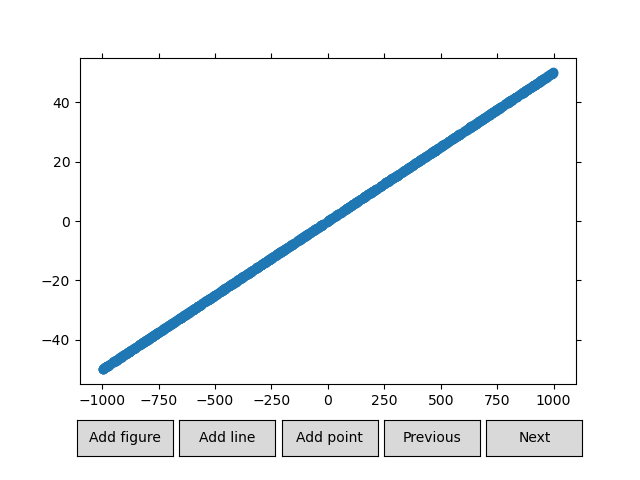

In [72]:
D1 = []
D1_single = []
D2 = []
a, b = (-1.0, 0.0), (1.0, 0.1)
AB = (b[0] - a[0], b[1] - a[1])
for _ in range(1000):
    x = random.uniform(-1000, 1000)
    t = (x - a[0]) / AB[0]
    y = a[1] + t * AB[1]
    D1.append((x, y))
    D1_single.append((np.single(x), np.single(y)))
    
    c = (a[1] - b[1])/(a[0] - b[0])
    d = a[1] - c * a[0]
    D2.append((x, c * x + d))

plot = Plot(points = [PointsCollection(D1)])
plot.draw()

## Functions for calculating the determinant of 2x2

In [73]:
def det2x2(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])

def det2x2_np(a, b, c):
    return np.linalg.det(np.array(((a[0] - c[0], a[1] - c[1]), (b[0] - c[0], b[1] - c[1]))))

## Functions for calculating the determinant of 3x3

In [74]:
def det3x3(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + c[0] * a[1] - b[1] * c[0] - b[0] * a[1] - a[0] * c[1]

def det3x3_np(a, b, c):
    return np.linalg.det(np.array(((a[0], a[1], 1), (b[0], b[1], 1), (c[0], c[1], 1))))

## Configuration of tolerance for 0

In [75]:
tolerances = [10**-18, 10**-13, 10**-8]
default = tolerances[0]
epsilon = {"a": default, "b": default, "c": default, "d": default}

## Function classifying points

In [76]:
def classify(points, det, epsilon, a, b):
    classified = {
        "left": [],
        "collinear": [],
        "right": []
    }
    
    for point in points:
        res = det(a, b, point)
        if res > epsilon:
            classified["right"].append(point)
        elif res < -epsilon:
            classified["left"].append(point)
        else:
            classified["collinear"].append(point)
    
    return classified

## Function displaying classified points

In [77]:
def printClassified(classified):
    plot = Plot(points = [PointsCollection(classified["left"], color = "green"), PointsCollection(classified["right"], color = "red"), PointsCollection(classified["collinear"], color = "yellow")])
    plot.draw()
    print("On the left: ", len(classified["left"]))
    print("Collinears: ", len(classified["collinear"]))
    print("On the right: ", len(classified["right"]))

# Comparisons for subpoint a)

## 1. Own 2x2 determinant

<IPython.core.display.Javascript object>


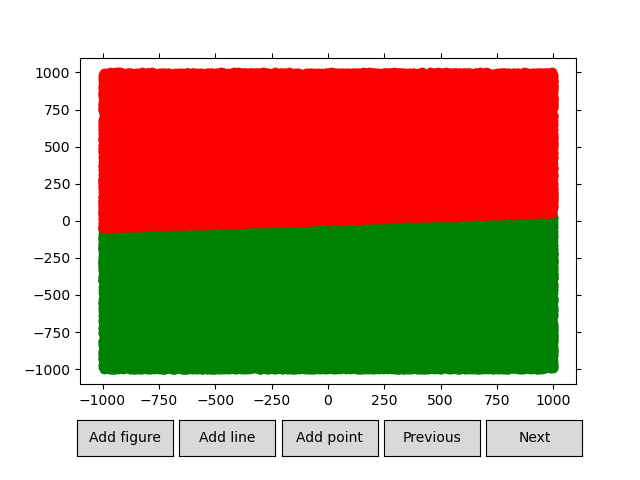

On the left:  50153
Collinears:  0
On the right:  49847


In [78]:
printClassified(classify(A, det2x2, epsilon['a'], a, b))

## 2. 2x2 determinant from NumPy

<IPython.core.display.Javascript object>


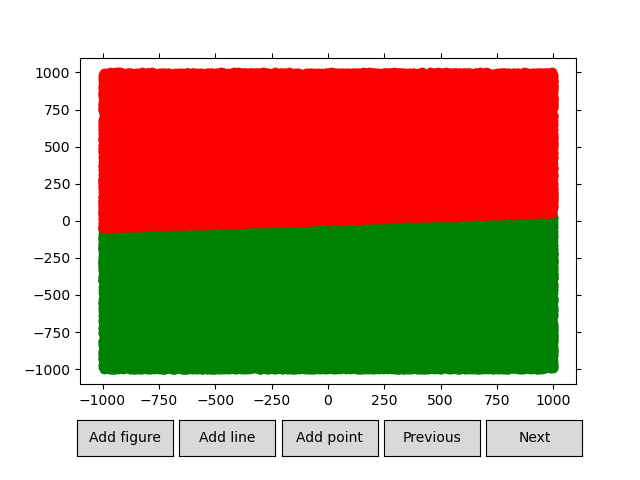

On the left:  50153
Collinears:  0
On the right:  49847


In [79]:
printClassified(classify(A, det2x2_np, epsilon['a'], a, b))

## 3. Own 3x3 determinant

<IPython.core.display.Javascript object>


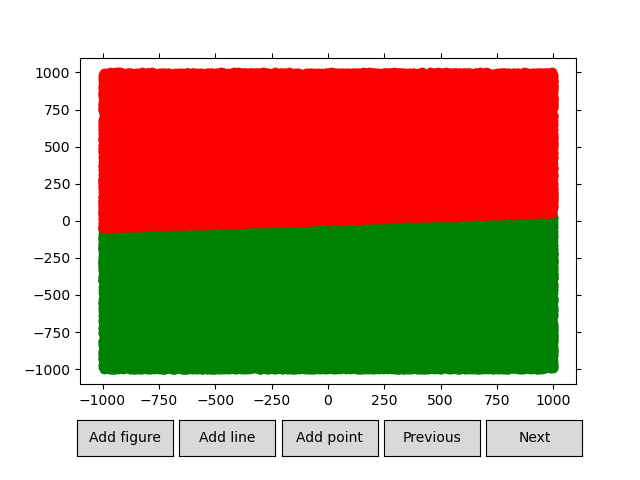

On the left:  50153
Collinears:  0
On the right:  49847


In [80]:
printClassified(classify(A, det3x3, epsilon['a'], a, b))

## 4. 3x3 determinant from NumPy

<IPython.core.display.Javascript object>


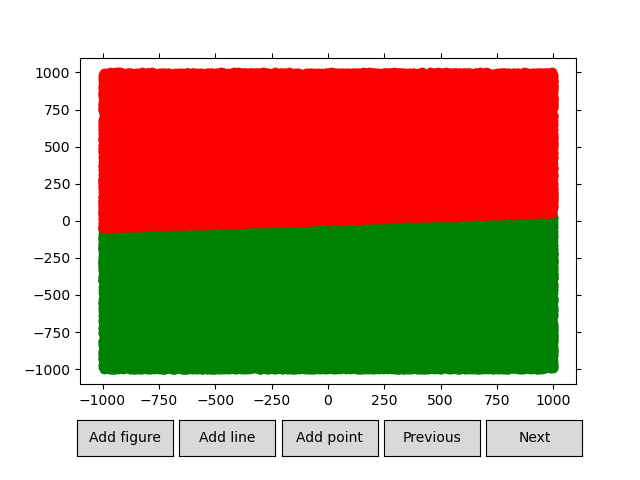

On the left:  50153
Collinears:  0
On the right:  49847


In [81]:
printClassified(classify(A, det3x3_np, epsilon['a'], a, b))

# Comparisons for subpoint b)

## 1. Own 2x2 determinant

<IPython.core.display.Javascript object>


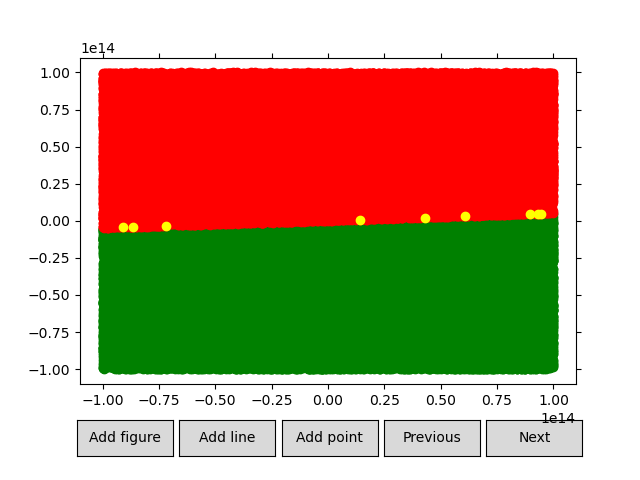

On the left:  49959
Collinears:  9
On the right:  50032


In [82]:
printClassified(classify(B, det2x2, epsilon['b'], a, b))

## 2. 2x2 determinant from NumPy

<IPython.core.display.Javascript object>


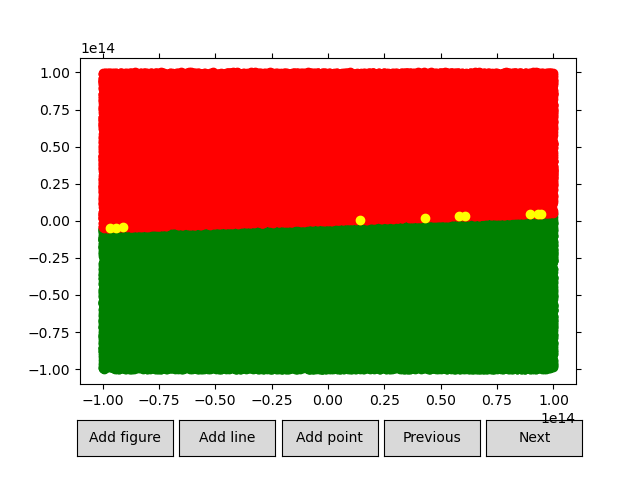

On the left:  49958
Collinears:  10
On the right:  50032


In [83]:
printClassified(classify(B, det2x2_np, epsilon['b'], a, b))

## 3. Own 3x3 determinant

<IPython.core.display.Javascript object>


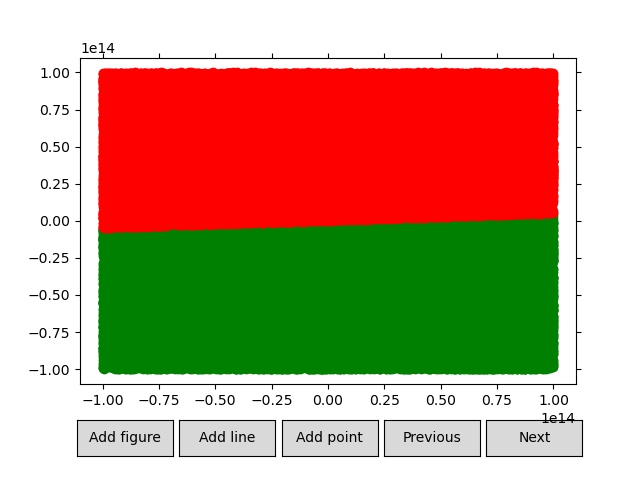

On the left:  49963
Collinears:  0
On the right:  50037


In [84]:
printClassified(classify(B, det3x3, epsilon['b'], a, b))

## 4. 3x3 determinant from NumPy

<IPython.core.display.Javascript object>


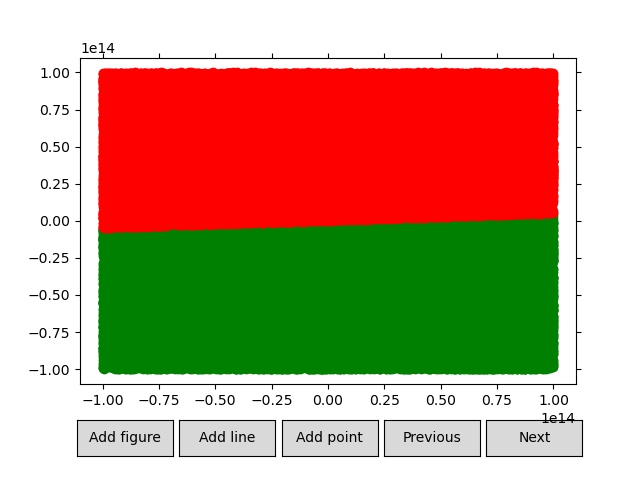

On the left:  49963
Collinears:  0
On the right:  50037


In [85]:
printClassified(classify(B, det3x3_np, epsilon['b'], a, b))

# Comparisons for subpoint c)

### 1. Own 2x2 determinant

<IPython.core.display.Javascript object>


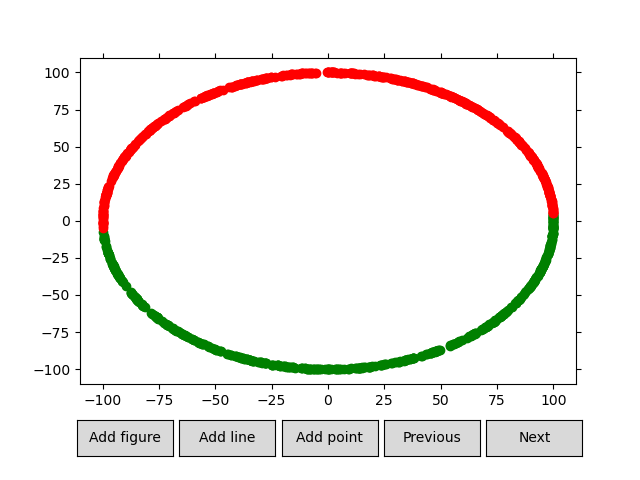

On the left:  494
Collinears:  0
On the right:  506


In [86]:
printClassified(classify(C, det2x2, epsilon['c'], a, b))

### 2. 2x2 determinant from NumPy

<IPython.core.display.Javascript object>


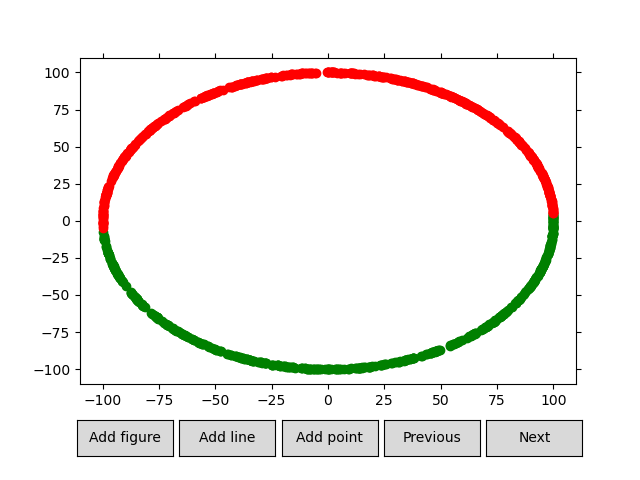

On the left:  494
Collinears:  0
On the right:  506


In [87]:
printClassified(classify(C, det2x2_np, epsilon['c'], a, b))

### 3. Own 3x3 determinant

<IPython.core.display.Javascript object>


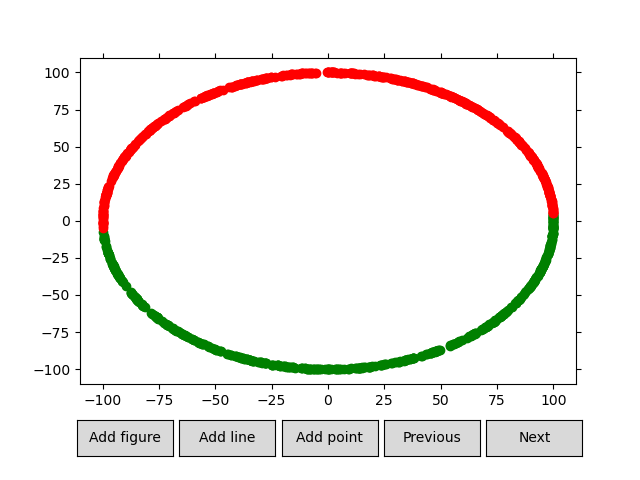

On the left:  494
Collinears:  0
On the right:  506


In [88]:
printClassified(classify(C, det3x3, epsilon['c'], a, b))

### 4. 3x3 determinant from NumPy

<IPython.core.display.Javascript object>


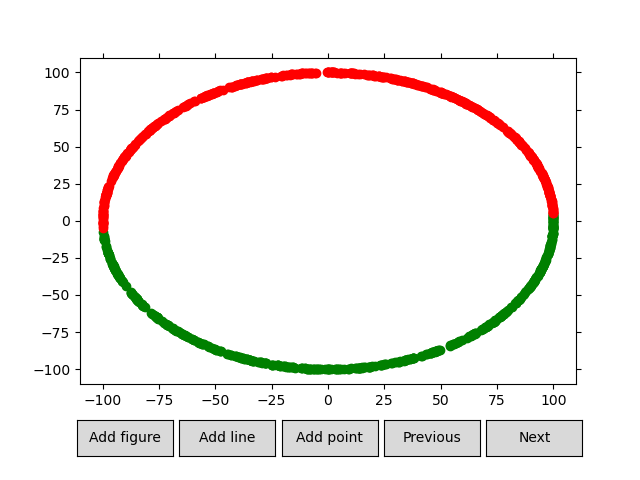

On the left:  494
Collinears:  0
On the right:  506


In [89]:
printClassified(classify(C, det3x3_np, epsilon['c'], a, b))

# Comparisons for subpoint d)

### 1. Own 2x2 determinant

####  I. Parametric form of the line

<IPython.core.display.Javascript object>


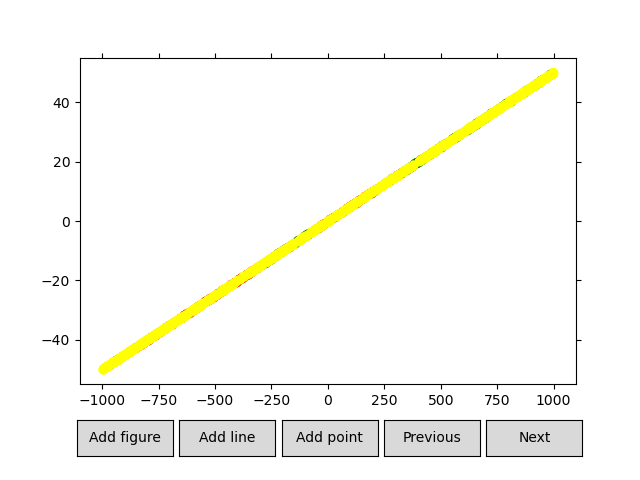

On the left:  149
Collinears:  695
On the right:  156


In [90]:
printClassified(classify(D1, det2x2, epsilon['d'], a, b))

#### II. Slope-intercept form of the line

<IPython.core.display.Javascript object>


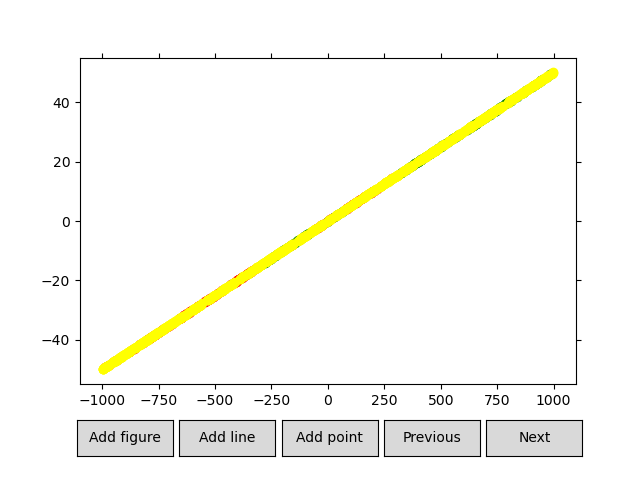

On the left:  161
Collinears:  679
On the right:  160


In [91]:
printClassified(classify(D2, det2x2, epsilon['d'], a, b))

### 2. 2x2 determinant from NumPy

#### I. Parametric form of the line

<IPython.core.display.Javascript object>


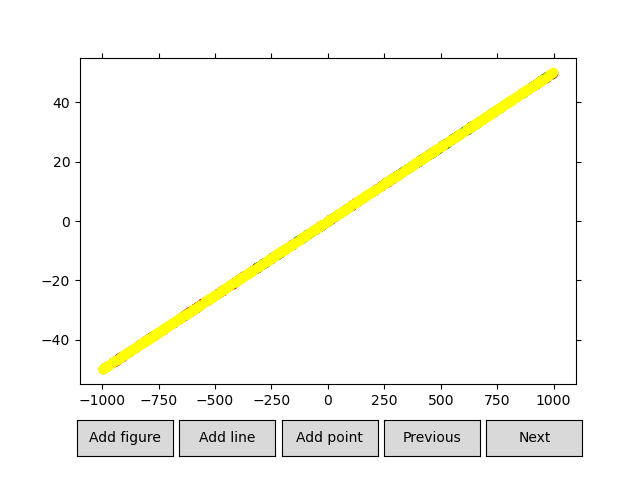

On the left:  159
Collinears:  684
On the right:  157


In [92]:
printClassified(classify(D1, det2x2_np, epsilon['d'], a, b))

#### II. Slope-intercept form of the line

<IPython.core.display.Javascript object>


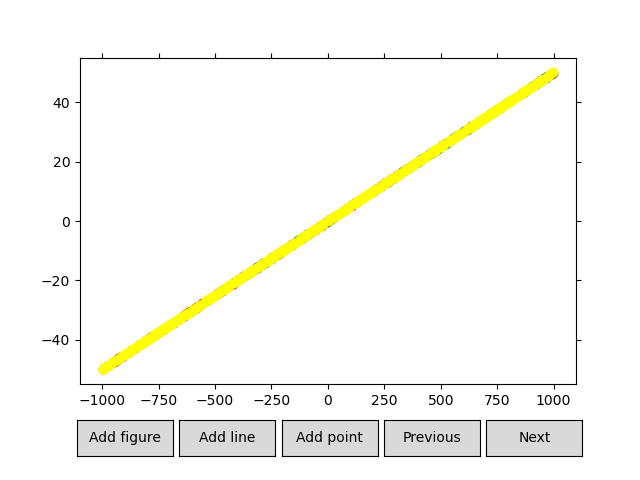

On the left:  160
Collinears:  682
On the right:  158


In [93]:
printClassified(classify(D2, det2x2_np, epsilon['d'], a, b))

### 3. Own 3x3 determinant

#### I. Parametric form of the line

<IPython.core.display.Javascript object>


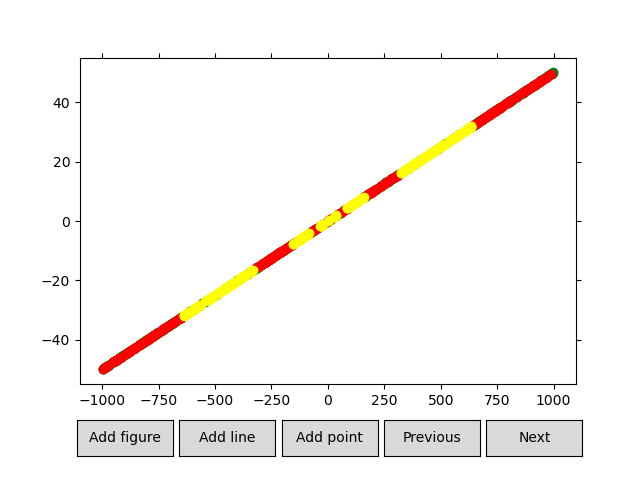

On the left:  421
Collinears:  315
On the right:  264


In [94]:
printClassified(classify(D1, det3x3, epsilon['d'], a, b))

#### II. Slope-intercept form of the line

<IPython.core.display.Javascript object>


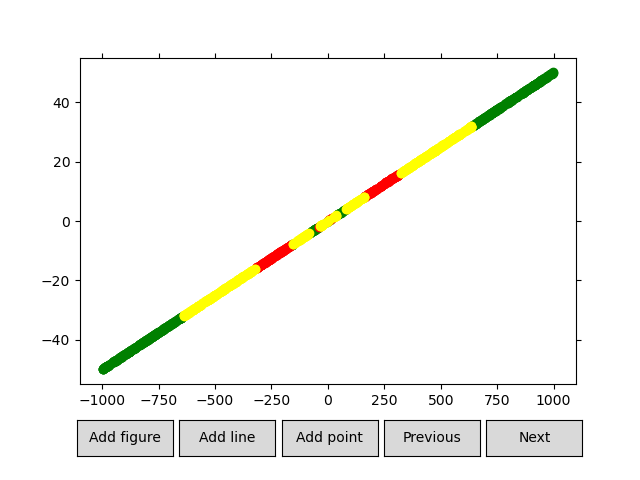

On the left:  421
Collinears:  400
On the right:  179


In [95]:
printClassified(classify(D2, det3x3, epsilon['d'], a, b))

### 4. 3x3 determinant from NumPy

#### I. Parametric form of the line

<IPython.core.display.Javascript object>


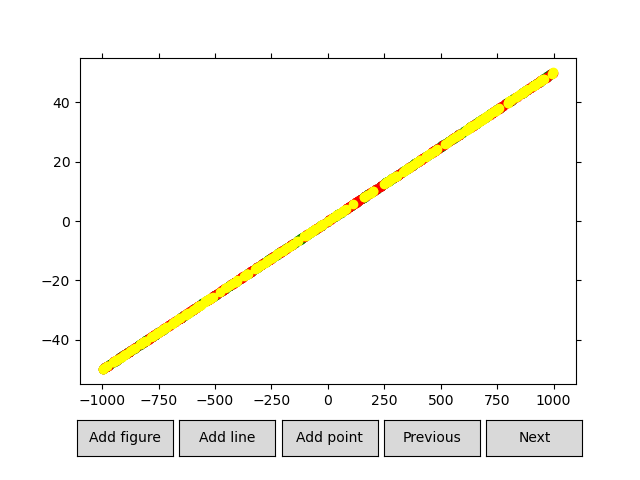

On the left:  397
Collinears:  252
On the right:  351


In [96]:
printClassified(classify(D1, det3x3_np, epsilon['d'], a, b))

#### II. Slope-intercept form of the line

<IPython.core.display.Javascript object>


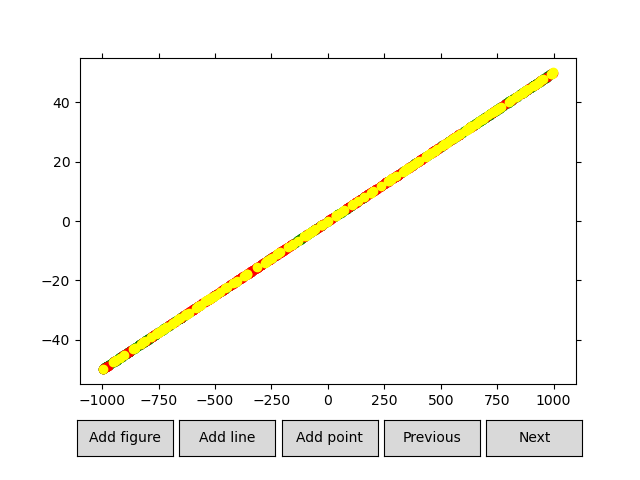

On the left:  436
Collinears:  186
On the right:  378


In [97]:
printClassified(classify(D2, det3x3_np, epsilon['d'], a, b))

## Function displaying differences in the classification of points

In [98]:
def drawDifferences(points, det1, det2, epsilon, a, b):
    getClassified1 = classify(points, det1, epsilon, a, b)
    res1 = []
    for key in getClassified1:
        for point in getClassified1[key]:
            res1.append((point, key))
        
    getClassified2 = classify(points, det2, epsilon, a, b)
    res2 = []
    for key in getClassified2:
        for point in getClassified2[key]:
            res2.append((point, key))
    
    res1.sort()
    res2.sort()
    diffsArr = []
    for i in range(len(res1)):
        if res1[i][1] != res2[i][1]:
            diffsArr.append(res1[i][0])
    
    if len(diffsArr) != 0:
        plot = Plot(points = [PointsCollection(diffsArr)])
        plot.draw()
    print(f"Differences: {len(diffsArr)}")

# Differences between determinants for all subpoints


### 1. Comparisons between own 2x2 determinant and 2x2 determinant from NumPy

In [99]:
drawDifferences(A, det2x2, det2x2_np, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


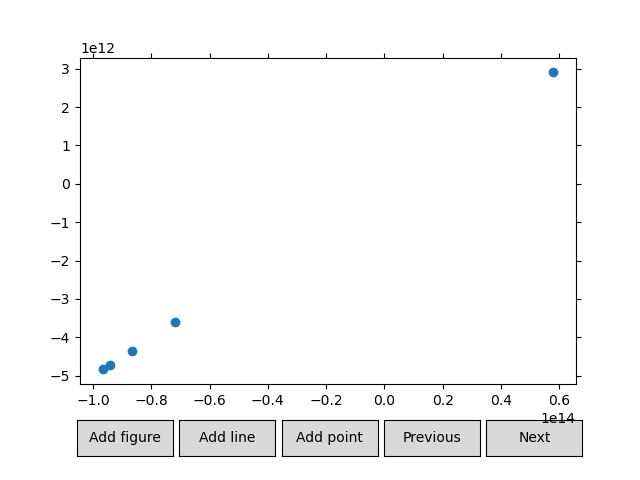

Differences: 5


In [100]:
drawDifferences(B, det2x2, det2x2_np, default, a, b)

In [101]:
drawDifferences(C, det2x2, det2x2_np, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


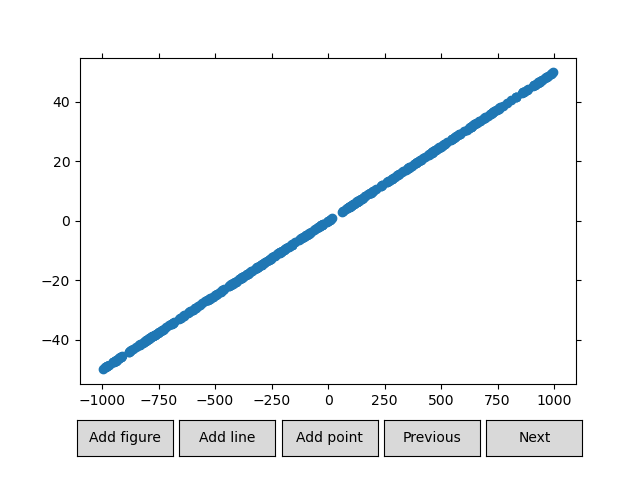

Differences: 417


In [102]:
drawDifferences(D1, det2x2, det2x2_np, default, a, b)

### 2. Comparisons between own 3x3 determinant and 3x3 determinant from NumPy

In [103]:
drawDifferences(A, det3x3, det3x3_np, default, a, b)

Differences: 0


In [104]:
drawDifferences(B, det3x3, det3x3_np, default, a, b)

Differences: 0


In [105]:
drawDifferences(C, det3x3, det3x3_np, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


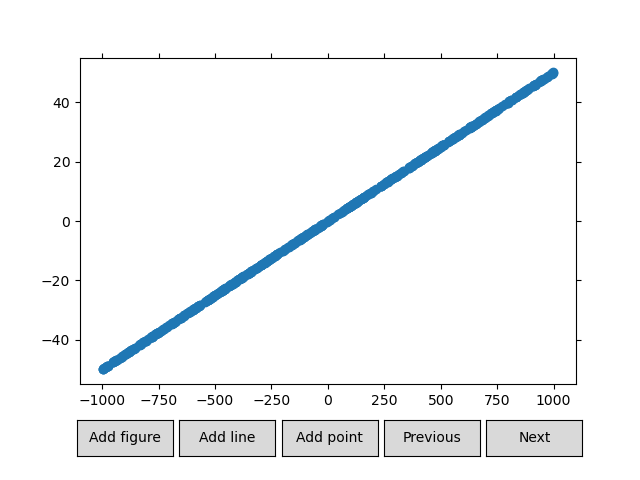

Differences: 544


In [106]:
drawDifferences(D1, det3x3, det3x3_np, default, a, b)

### 3. Comparisons between own 2x2 determinant and 3x3 determinant from NumPy

In [107]:
drawDifferences(A, det2x2, det3x3_np, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


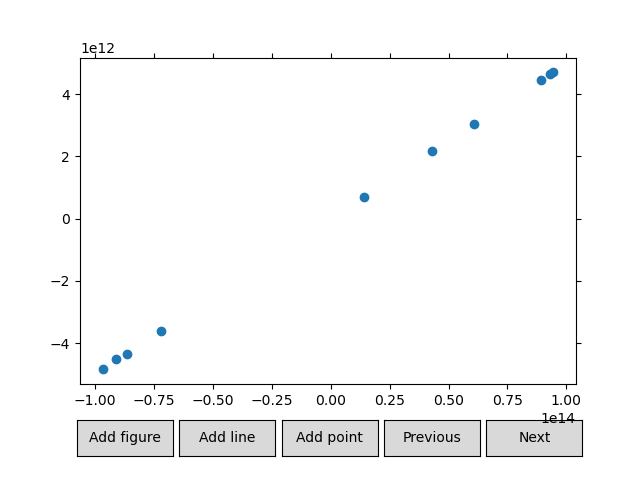

Differences: 10


In [108]:
drawDifferences(B, det2x2, det3x3_np, default, a, b)

In [109]:
drawDifferences(C, det2x2, det3x3_np, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


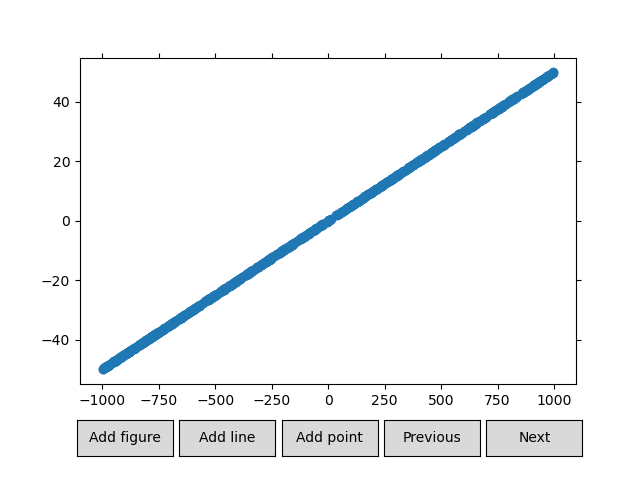

Differences: 693


In [110]:
drawDifferences(D1, det2x2, det3x3_np, default, a, b)

### 4. Comparisons between own 2x2 determinant and own 3x3 determinant

In [111]:
drawDifferences(A, det2x2, det3x3, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


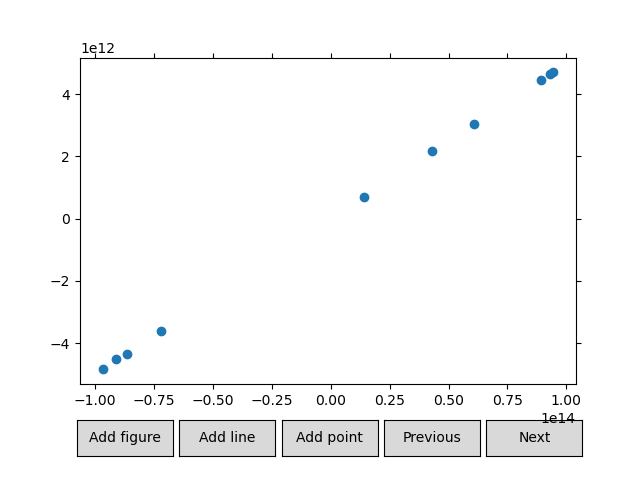

Differences: 10


In [112]:
drawDifferences(B, det2x2, det3x3, default, a, b)

In [113]:
drawDifferences(C, det2x2, det3x3, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


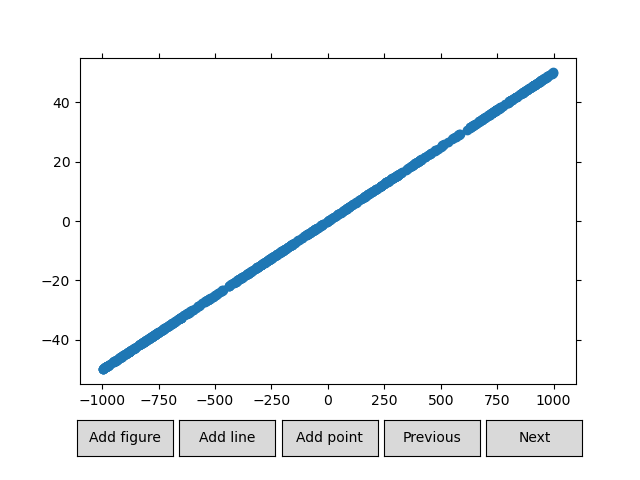

Differences: 725


In [114]:
drawDifferences(D1, det2x2, det3x3, default, a, b)

### 5. Comparisons between 2x2 and 3x3 determinants from NumPy

In [115]:
drawDifferences(A, det2x2_np, det3x3_np, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


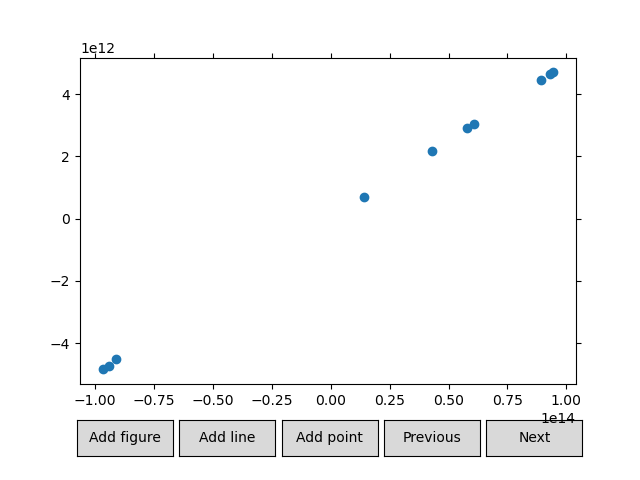

Differences: 10


In [116]:
drawDifferences(B, det2x2_np, det3x3_np, default, a, b)

In [117]:
drawDifferences(C, det2x2_np, det3x3_np, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


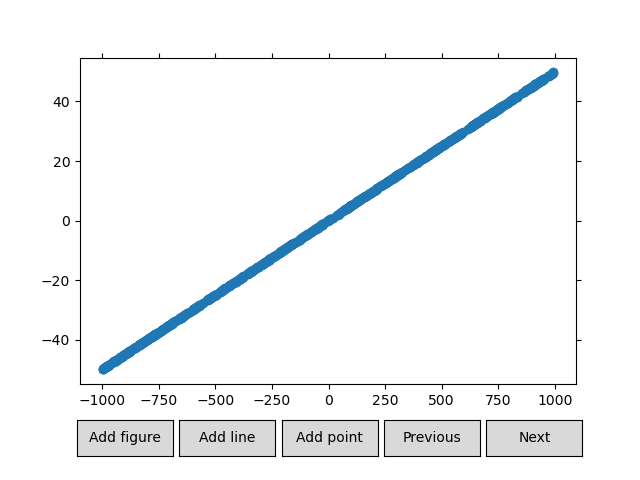

Differences: 683


In [118]:
drawDifferences(D1, det2x2_np, det3x3_np, default, a, b)

### 6. Comparisons between own 3x3 determinant and 2x2 determinant from NumPy

In [119]:
drawDifferences(A, det2x2_np, det3x3, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


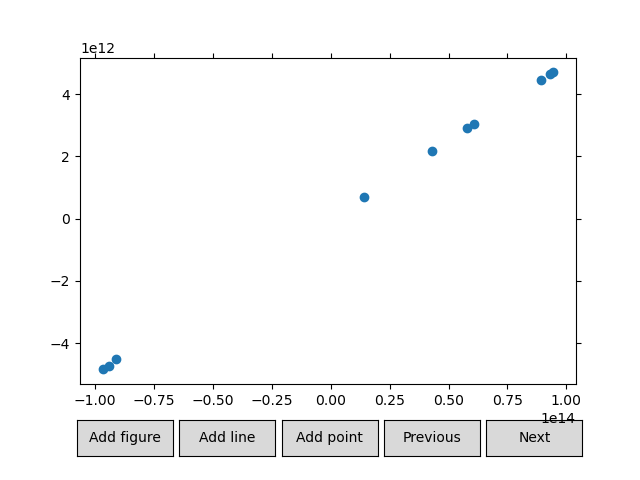

Differences: 10


In [120]:
drawDifferences(B, det2x2_np, det3x3, default, a, b)

In [121]:
drawDifferences(C, det2x2_np, det3x3, default, a, b)

Differences: 0


<IPython.core.display.Javascript object>


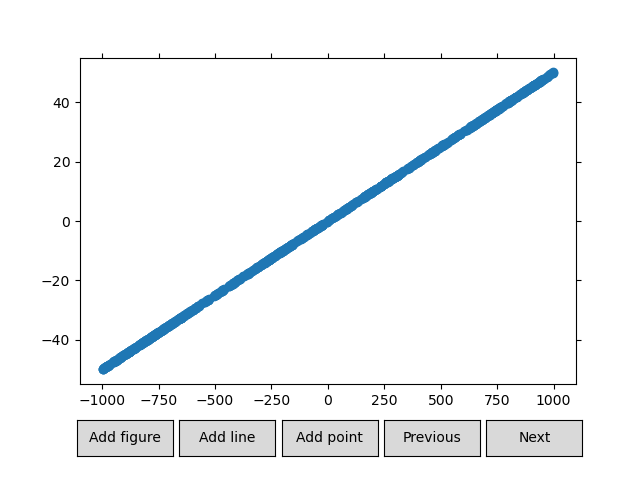

Differences: 718


In [122]:
drawDifferences(D1, det2x2_np, det3x3, default, a, b)

## Function displaying as a slide the classification differences for all combinations of determinants and tolerances

In [123]:
def compare(points):
    scenes = []
    determinants = [(det2x2, "own 2x2"), (det2x2_np, "2x2 numpy"), (det3x3, "own 3x3"), (det3x3_np, "3x3 numpy")]
    for curr_set, text_set in points:
        print(f"\t\t\t[Precision {text_set}]\n")
        for det, txt in determinants:
            print(f"\t\t[Determinant {txt}]")
            for epsilon in tolerances:
                classified = classify(curr_set, det, epsilon, a, b)
                left_len, collinear_len, right_len = len(classified["left"]), len(classified["collinear"]), len(classified["right"])
                print(f"[Tolerance: {epsilon}], Left: {left_len}, Collinear: {collinear_len}, Right: {right_len}")
                scenes.append(Scene([PointsCollection(classified["left"], color = "red"), PointsCollection(classified["right"], color = "green"), PointsCollection(classified['collinear'], color='yellow')]))
            print("\n")
        print("\n\n")
    return scenes

# Comparison of all combinations of determinants and tolerances

### Subpoint a)

			[Precision float64]

		[Determinant own 2x2]
[Tolerance: 1e-18], Left: 50153, Collinear: 0, Right: 49847
[Tolerance: 1e-13], Left: 50153, Collinear: 0, Right: 49847
[Tolerance: 1e-08], Left: 50153, Collinear: 0, Right: 49847


		[Determinant 2x2 numpy]
[Tolerance: 1e-18], Left: 50153, Collinear: 0, Right: 49847
[Tolerance: 1e-13], Left: 50153, Collinear: 0, Right: 49847
[Tolerance: 1e-08], Left: 50153, Collinear: 0, Right: 49847


		[Determinant own 3x3]
[Tolerance: 1e-18], Left: 50153, Collinear: 0, Right: 49847
[Tolerance: 1e-13], Left: 50153, Collinear: 0, Right: 49847
[Tolerance: 1e-08], Left: 50153, Collinear: 0, Right: 49847


		[Determinant 3x3 numpy]
[Tolerance: 1e-18], Left: 50153, Collinear: 0, Right: 49847
[Tolerance: 1e-13], Left: 50153, Collinear: 0, Right: 49847
[Tolerance: 1e-08], Left: 50153, Collinear: 0, Right: 49847





			[Precision float32]

		[Determinant own 2x2]
[Tolerance: 1e-18], Left: 49842, Collinear: 0, Right: 50158
[Tolerance: 1e-13], Left: 49842, Coll

<IPython.core.display.Javascript object>


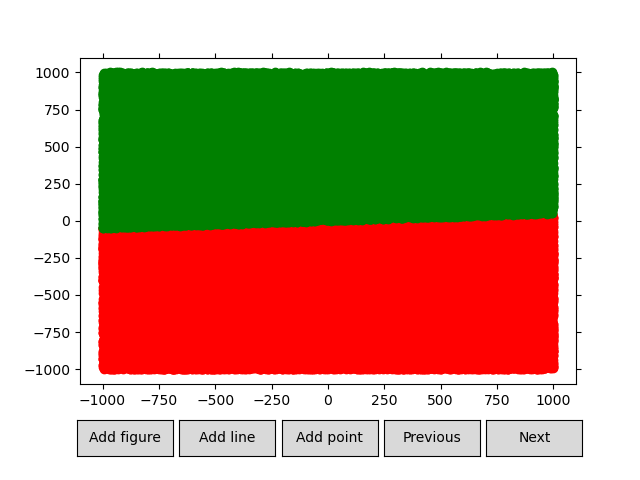

In [124]:
plot = Plot(scenes = compare([(A, "float64"), (A_single, "float32")]))
plot.draw()

### Subpoint b)

			[Precision float64]

		[Determinant own 2x2]
[Tolerance: 1e-18], Left: 49959, Collinear: 9, Right: 50032
[Tolerance: 1e-13], Left: 49959, Collinear: 9, Right: 50032
[Tolerance: 1e-08], Left: 49959, Collinear: 9, Right: 50032


		[Determinant 2x2 numpy]
[Tolerance: 1e-18], Left: 49958, Collinear: 10, Right: 50032
[Tolerance: 1e-13], Left: 49958, Collinear: 10, Right: 50032
[Tolerance: 1e-08], Left: 49958, Collinear: 10, Right: 50032


		[Determinant own 3x3]
[Tolerance: 1e-18], Left: 49963, Collinear: 0, Right: 50037
[Tolerance: 1e-13], Left: 49963, Collinear: 0, Right: 50037
[Tolerance: 1e-08], Left: 49963, Collinear: 0, Right: 50037


		[Determinant 3x3 numpy]
[Tolerance: 1e-18], Left: 49963, Collinear: 0, Right: 50037
[Tolerance: 1e-13], Left: 49963, Collinear: 0, Right: 50037
[Tolerance: 1e-08], Left: 49963, Collinear: 0, Right: 50037





			[Precision float32]

		[Determinant own 2x2]
[Tolerance: 1e-18], Left: 49888, Collinear: 8, Right: 50104
[Tolerance: 1e-13], Left: 49888, C

<IPython.core.display.Javascript object>


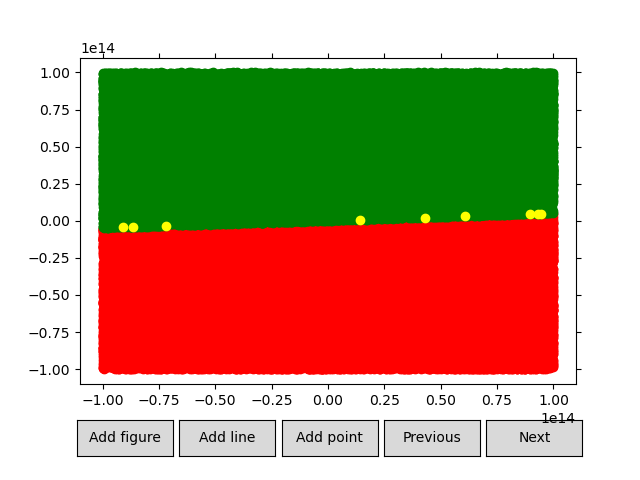

In [125]:
plot = Plot(scenes = compare([(B, "float64"), (B_single, "float32")]))
plot.draw()

### Subpoint c)

			[Precision float64]

		[Determinant own 2x2]
[Tolerance: 1e-18], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-13], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-08], Left: 494, Collinear: 0, Right: 506


		[Determinant 2x2 numpy]
[Tolerance: 1e-18], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-13], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-08], Left: 494, Collinear: 0, Right: 506


		[Determinant own 3x3]
[Tolerance: 1e-18], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-13], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-08], Left: 494, Collinear: 0, Right: 506


		[Determinant 3x3 numpy]
[Tolerance: 1e-18], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-13], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-08], Left: 494, Collinear: 0, Right: 506





			[Precision float32]

		[Determinant own 2x2]
[Tolerance: 1e-18], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-13], Left: 494, Collinear: 0, Right: 506
[Tolerance: 1e-08], Left: 494, Co

<IPython.core.display.Javascript object>


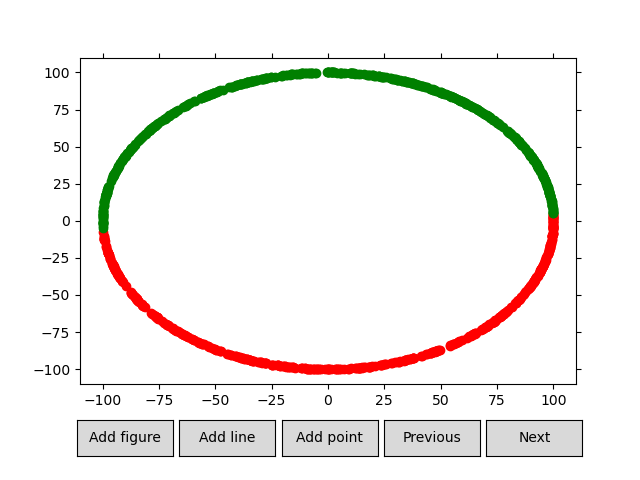

In [126]:
plot = Plot(scenes = compare([(C, "float64"), (C_single, "float32")]))
plot.draw()

### Subpoint d)

			[Precision float64]

		[Determinant own 2x2]
[Tolerance: 1e-18], Left: 149, Collinear: 695, Right: 156
[Tolerance: 1e-13], Left: 135, Collinear: 728, Right: 137
[Tolerance: 1e-08], Left: 0, Collinear: 1000, Right: 0


		[Determinant 2x2 numpy]
[Tolerance: 1e-18], Left: 159, Collinear: 684, Right: 157
[Tolerance: 1e-13], Left: 144, Collinear: 719, Right: 137
[Tolerance: 1e-08], Left: 0, Collinear: 1000, Right: 0


		[Determinant own 3x3]
[Tolerance: 1e-18], Left: 421, Collinear: 315, Right: 264
[Tolerance: 1e-13], Left: 0, Collinear: 1000, Right: 0
[Tolerance: 1e-08], Left: 0, Collinear: 1000, Right: 0


		[Determinant 3x3 numpy]
[Tolerance: 1e-18], Left: 397, Collinear: 252, Right: 351
[Tolerance: 1e-13], Left: 0, Collinear: 1000, Right: 0
[Tolerance: 1e-08], Left: 0, Collinear: 1000, Right: 0





			[Precision float32]

		[Determinant own 2x2]
[Tolerance: 1e-18], Left: 417, Collinear: 154, Right: 429
[Tolerance: 1e-13], Left: 416, Collinear: 158, Right: 426
[Tolerance: 1e-08], Lef

<IPython.core.display.Javascript object>


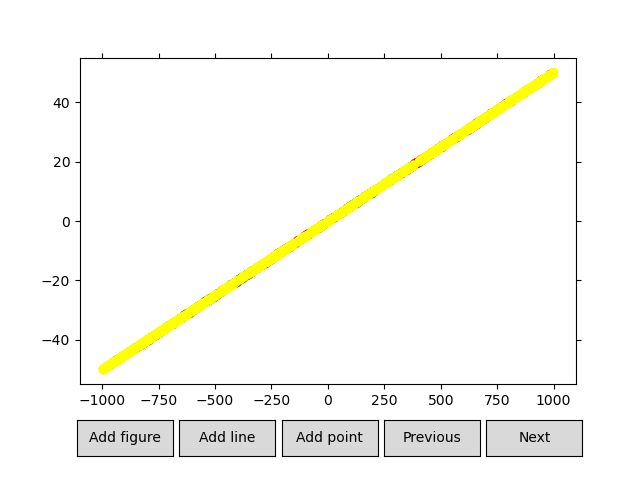

In [127]:
plot = Plot(scenes = compare([(D1, "float64"), (D1_single, "float32")]))
plot.draw()

## Comparison of execution times for all determinants

In [129]:
import time
start = time.time()
classify(A, det2x2, default, a, b)
print("[Own 2x2 determinant]:", time.time() - start)

start = time.time()
classify(A, det2x2_np, default, a, b)
print("[2x2 determinant from NumPy]:", time.time() - start)

start = time.time()
classify(A, det3x3, default, a, b)
print("[Own 3x3 determinant]:", time.time() - start)

start = time.time()
classify(A, det3x3_np, default, a, b)
print("[3x3 determinant from NumPy]:", time.time() - start)

[Own 2x2 determinant]: 0.07452964782714844
[2x2 determinant from NumPy]: 0.9657316207885742
[Own 3x3 determinant]: 0.10399198532104492
[3x3 determinant from NumPy]: 1.0730106830596924
